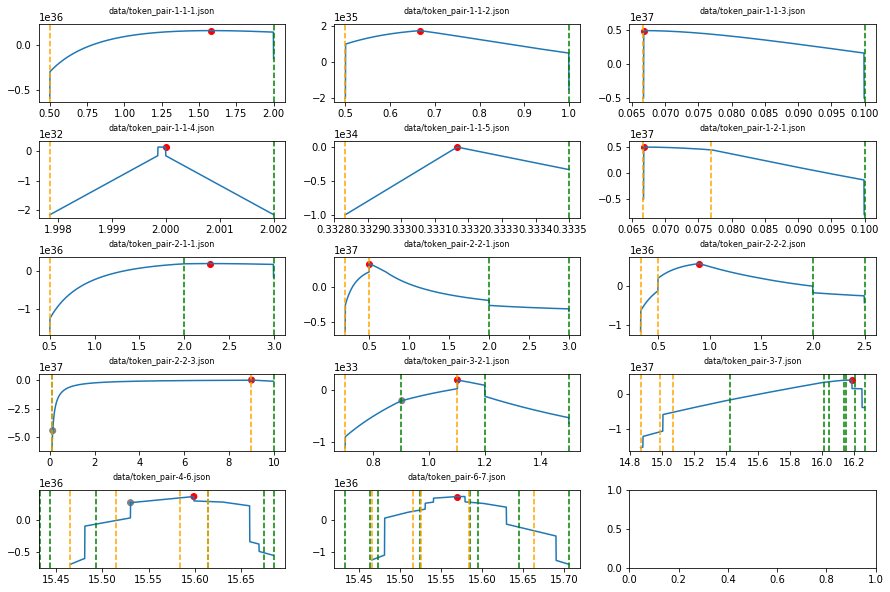

In [8]:
import json
from src.token_pair_solver.orderbook import compute_objective_rational
from src.token_pair_solver.amount import compute_buy_amounts
from src.core.api import Fee
from src.token_pair_solver.api import load_problem
import matplotlib.pyplot as plt
from math import ceil
from fractions import Fraction as F
#%matplotlib notebook

b_buy_token_price=int(1e18)
fee = Fee(token='token0', value=F(1, 1000))

def plot_objective_function(ax, b_orders, s_orders):
    xrate_ub = max(order.max_xrate for order in b_orders)
    xrate_lb = min(1 / order.max_xrate for order in s_orders)
    x = []
    y = []
    nr_steps = 1000
    for i in range(0,nr_steps):
        xrate = xrate_lb + i * (xrate_ub - xrate_lb) / nr_steps
        compute_buy_amounts(
            xrate, b_orders, s_orders, fee=fee
        )
        obj = compute_objective_rational(
            b_orders, s_orders, [], xrate,
            b_buy_token_price=b_buy_token_price,
            fee=fee
        )
        x.append(xrate)
        y.append(obj)
    ax.plot(x,y)

def plot_local_optima(ax, b_orders, s_orders):
    from src.token_pair_solver.xrate import SymbolicSolver as Solver
    from src.token_pair_solver.xrate import xrate_interval_iterator

    solver = Solver(fee)
    xrates_obj = [
        solver.solve_interval(
            xrate_lb, xrate_ub, b_exec_orders, s_exec_orders
        )
        for xrate_lb, xrate_ub, b_exec_orders, s_exec_orders
        in xrate_interval_iterator(b_orders, s_orders, fee)
    ]
    xrates_obj = [(xrate, obj) for xrate, obj in xrates_obj if xrate is not None]
    if len(xrates_obj) == 0:
        return
    xx = [x for x, y in xrates_obj]
    yy = [b_buy_token_price * y for x, y in xrates_obj]
    opt = max(yy)
    cc = ["grey" if y < opt else "r" for y in yy]
    ax.scatter(x=xx, y=yy, c=cc)

def plot_max_xrates(ax, b_orders, s_orders):
    for b_order in b_orders:
        ax.axvline(x=b_order.max_xrate, c="g", ls="--")  
    for s_order in s_orders:
        ax.axvline(x=1/s_order.max_xrate, c="orange", ls="--")  


def plot_instance(ax, b_orders, s_orders):
    plot_objective_function(ax, b_orders, s_orders)
    plot_local_optima(ax, b_orders, s_orders)
    plot_max_xrates(ax, b_orders, s_orders)


def plot_one(fname):
    with open(fname, "r") as f:
        instance = json.load(f)
    _, b_orders, s_orders, _, _ = load_problem(instance, ('token0', 'token1'))
    plot_instance(plt, b_orders, s_orders)

def plot_grid(fnames, max_plots_per_row=3):
    f, axs = plt.subplots(
        ceil(len(fnames) / max_plots_per_row),
        max_plots_per_row,
        gridspec_kw={
            "wspace": .2,
            "hspace": .5
        },
        figsize=[15, 10]
    )
    for i, fname in enumerate(fnames):
        with open(fname, "r") as f:
            instance = json.load(f)
        _, b_orders, s_orders, _, _ = load_problem(instance, ('token0', 'token1'))
        ax = axs[i // max_plots_per_row, i % max_plots_per_row]
        ax.set_title(fname, fontdict={'fontsize': 8}, pad=10)
        plot_instance(
            ax,
            b_orders,
            s_orders
        )
    return f

def get_fnames(subdir="data"):
    import glob
    return sorted(glob.glob(subdir + "/*.json"))

fig = plot_grid(get_fnames())
#fig.savefig("obj_zoo.pdf", bbox_inches='tight')
#fname="data/token_pair-3-2-1.json"
#fname="../dex-solver/results/01_instance_int.json"
#plot_one(fname)

In [ ]:
s . b s b
s b . s b
s b s . b